# Comparison of H2 and stellar surface density

In [1]:
import os
import numpy as np
from astropy.table import Table, join, Column
import matplotlib.pyplot as plt
from astropy import units as u
from scipy import stats
from edge_pydb import EdgeTable
from edge_pydb.xy2hist import xy2hist
#from edge_pydb.conversion import gc_polr, stmass_pc2, msd_co, ZOH_M13
params = {'mathtext.default': 'regular'} 
plt.rcParams.update(params)
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Read the observational values

In [2]:
fluxcols = ['Name','ix','iy','flux_Halpha_sm','flux_Hbeta_sm','e_flux_Halpha_sm',
          'flux_[NII]6583_sm','flux_[OIII]5007_sm','EW_Halpha_sm','ZOH_sm']
sspcols = ['Name','ix','iy','mass_ssp_sm','sigstar_sm']
try:
    hatab = EdgeTable('edge.pipe3d.hdf5', path='flux_elines_sm', 
                      cols=fluxcols)
    sttab = EdgeTable('edge.pipe3d.hdf5', path='SSP_sm', 
                      cols=sspcols)
    cotab = EdgeTable('edge.comom_smo7.hdf5', path='smo')
    print('Working on full EDGE database')
except:
    hatab = EdgeTable('NGC4047.pipe3d.hdf5', path='flux_elines_sm', 
                  cols=fluxcols)
    sttab = EdgeTable('NGC4047.pipe3d.hdf5', path='SSP_sm', 
                  cols=sspcols)
    cotab = EdgeTable('NGC4047.comom_smo7.hdf5', path='smo')
    print('Working on NGC 4047 data')

Working on full EDGE database


In [3]:
cotab.join(hatab, keys=['Name','ix','iy'])
cotab.join(sttab, keys=['Name','ix','iy'])
# For normalized radius we need R25
leda    = EdgeTable('edge_leda.csv', cols=['Name','ledaD25'])
cotab.join(leda)
print(cotab.colnames)

['Name', 'ix', 'iy', 'ra_off', 'dec_off', 'rad_arc', 'azi_ang', 'snrpk_12', 'mom0_12', 'emom0_12', 'sigmol', 'e_sigmol', 'sigmol_fo', 'e_sigmol_fo', 'snrpk_13', 'mom0_13', 'emom0_13', 'flux_Halpha_sm', 'flux_Hbeta_sm', 'e_flux_Halpha_sm', 'flux_[NII]6583_sm', 'flux_[OIII]5007_sm', 'EW_Halpha_sm', 'ZOH_sm', 'mass_ssp_sm', 'sigstar_sm', 'ledaD25']


## Calculate histograms of physical values

In [4]:
# add a column for r/r25
r25 = 0.5*(cotab['ledaD25'].quantity).to(u.arcsec)
rr25 = Column(data=cotab['rad_arc']/r25.value, unit=None, name='rr25')
print('Calculated {} for {} points'.format('rr25',len(rr25)))
cotab.add_column(rr25)
print(cotab.colnames)

Calculated rr25 for 231125 points
['Name', 'ix', 'iy', 'ra_off', 'dec_off', 'rad_arc', 'azi_ang', 'snrpk_12', 'mom0_12', 'emom0_12', 'sigmol', 'e_sigmol', 'sigmol_fo', 'e_sigmol_fo', 'snrpk_13', 'mom0_13', 'emom0_13', 'flux_Halpha_sm', 'flux_Hbeta_sm', 'e_flux_Halpha_sm', 'flux_[NII]6583_sm', 'flux_[OIII]5007_sm', 'EW_Halpha_sm', 'ZOH_sm', 'mass_ssp_sm', 'sigstar_sm', 'ledaD25', 'rr25']


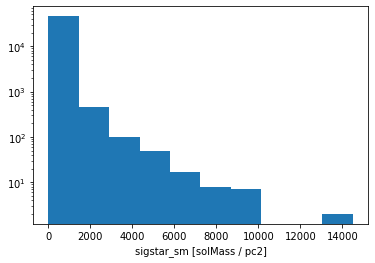

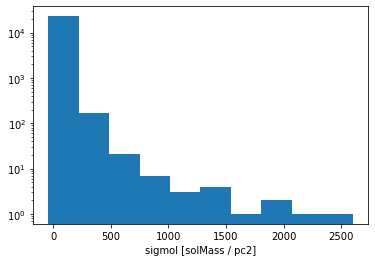

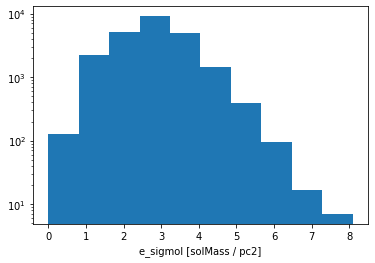

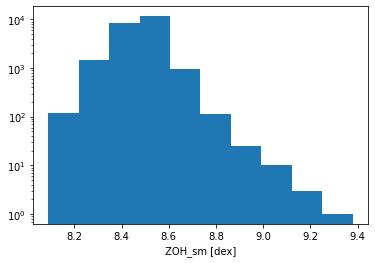

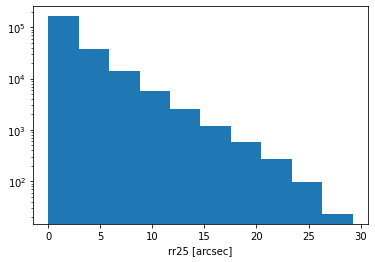

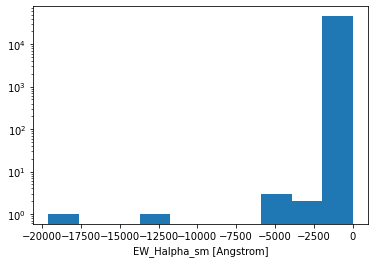

In [5]:
for column in ['sigstar_sm', 'sigmol', 'e_sigmol', 'ZOH_sm', 'rr25', 'EW_Halpha_sm']:
    not_nan = (~np.isnan(cotab[column]))
    plt.hist(cotab[column][not_nan],log=True)
    plt.xlabel(column+' ['+str(cotab[column].unit)+']')
    plt.show()
    plt.close()

## Make the plots

In [6]:
# Plot limits and labels
xlabel = '$\Sigma_*\ [M_\odot\, pc^{-2}]$'
ylabel = '$\Sigma_{H2}\ [M_\odot\, pc^{-2}]$'
xrange = [0, 4]
yrange = [0, 4]

# 10% line
xsca = np.logspace(xrange[0],xrange[1],100)
ysca = xsca/10.

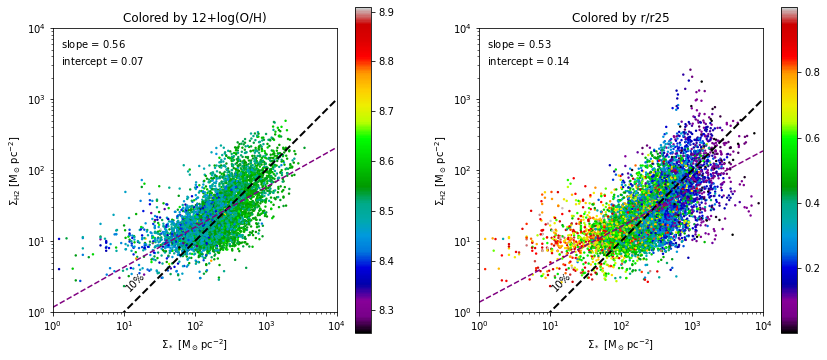

In [7]:
# Scatter X vs Y colored by Z, CO detections only
fig, ax = plt.subplots(1,2,figsize=(14,6))
cmap = plt.cm.get_cmap('nipy_spectral')
for i, zcolumn in enumerate(['ZOH_sm', 'rr25']):
    xdata = cotab['sigstar_sm']
    ydata = cotab['sigmol']
    zdata = cotab[zcolumn]
    goodidx = (xdata>0) & (ydata>0) & (zdata>0) & (cotab['rr25']<1)
    detidx = goodidx & (cotab['sigmol']>3*cotab['e_sigmol'])
    xdata = xdata[detidx]
    ydata = ydata[detidx]
    zdata = zdata[detidx]
    sc = ax[i].scatter(xdata, ydata, marker='o', c=zdata, edgecolors='none', s=6, cmap=cmap)
    # Plot 10% line
    ax[i].plot(xsca, ysca, linestyle='--', lw=2, color='k')
    ax[i].text(10, 2, '10%', rotation=45)
    # Plot colorbar
    fig.colorbar(sc, ax=ax[i])
    # Plot linear regression
    sorted=np.argsort(xdata)
    m, b, rval, pval, std_err = stats.linregress(np.log10(xdata[sorted]),
        np.log10(ydata[sorted]))
    ymod = b+m*np.log10(xsca)
    ax[i].plot(xsca, 10**(ymod), linestyle='--', color='purple')
    ax[i].text(0.03,0.93,'slope = $%4.2f$' % m,size=10,transform=ax[i].transAxes)
    ax[i].text(0.03,0.87,'intercept = $%4.2f$' % b,size=10,transform=ax[i].transAxes)
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    if i==0:
        title='12+log(O/H)'
    else:
        title='r/r25'
    ax[i].set_title('Colored by '+title)
    ax[i].set_xlim(10**xrange[0], 10**xrange[1])
    ax[i].set_ylim(10**yrange[0], 10**yrange[1])
    ax[i].set_xlabel(xlabel)
    ax[i].set_ylabel(ylabel)
    ax[i].set_aspect('equal')
plt.show()

Excluding 221528 invalid values
Number of detection points: 9597


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  del sys.path[0]


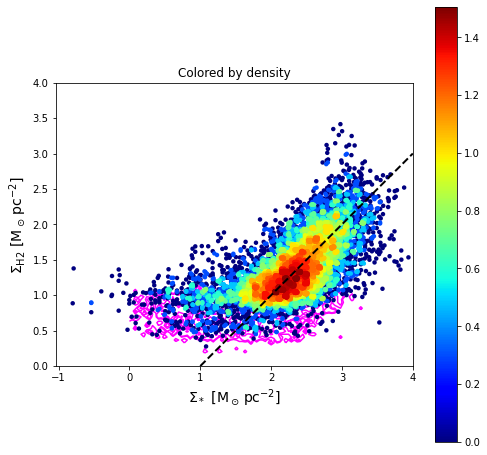

In [8]:
# Histogram of X vs Y
det = ((~np.isnan(cotab['sigstar_sm'])) & 
       (~np.isnan(cotab['sigmol'])) & 
       (cotab['sigmol']>3*cotab['e_sigmol']) &
       (cotab['sigstar_sm']>0))
print('Excluding {} invalid values'.format(len(np.nonzero(~det)[0])))
print('Number of detection points:',len(np.nonzero(det)[0]))
x_det, y_det, z_det, *hist = xy2hist(cotab['sigstar_sm'][det], cotab['sigmol'][det], log=True)

# Plot the detections as colored points
fig, ax = plt.subplots(figsize=(8,8))
cm = plt.cm.get_cmap('jet')
sc = ax.scatter(x_det, y_det, c=z_det, s=20, edgecolor='', cmap=cm, zorder=2)

# Plot the upper limits as contours
nbins = 100
xbins = np.linspace(xrange[0], xrange[1], nbins)
ybins = np.linspace(yrange[0], yrange[1], nbins)
ulim = ((cotab['sigstar_sm']>0) & 
        ((np.isnan(cotab['sigmol'])) | (cotab['sigmol']<3*cotab['e_sigmol'])))
H2, xedges, yedges = np.histogram2d(np.log10(cotab['sigstar_sm'][ulim]),
                                      np.log10(3*cotab['e_sigmol'][ulim]),
                                      bins=(xbins,ybins))
H2 = np.transpose(H2)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
levels = [1, 2, 5, 10, 20, 50, 100, 200]
cmap = ax.contour(H2, colors='magenta', extent=extent, levels=levels, zorder=1)

# Plot the 10% line
xsca = np.linspace(1,4,10)
ysca = xsca - 1
ax.plot(xsca, ysca, linestyle='--', lw=2, color='k')

plt.xlabel(xlabel,fontsize=14)
plt.ylabel(ylabel,fontsize=14)
ax.set_title('Colored by density')
ax.set_aspect('equal')
plt.colorbar(sc)